In [14]:
!pip install snowflake-connector-python[pandas]
!pip install holidays
!pip install --upgrade snowflake-sqlalchemy
!pip install imblearn
!pip install catboost

import re
import snowflake.connector
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import boto3
import base64
from numpy import dtype, isnan, sqrt
from sqlalchemy import create_engine
from sqlalchemy import pool
from sqlalchemy.dialects import registry
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives.asymmetric import rsa
from cryptography.hazmat.primitives.asymmetric import dsa
from cryptography.hazmat.primitives import serialization
from botocore.exceptions import ClientError
from snowflake.connector.pandas_tools import write_pandas, pd_writer
from dateutil.easter import *
from pathlib import Path
from imblearn.over_sampling import SMOTE
import gc
import dask.dataframe as dd
import dask
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostClassifier
import catboost
import time


import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import SVC
%matplotlib inline

In [64]:
df = pd.read_csv('chalice_frame_data.csv')
df

Columns (0,5,7) have mixed types.Specify dtype option on import or set low_memory=False.


,hashed_email,age,gender,country,ethnicity,postcode,brand,aspect_ratio,ad_length,context_platform,...,ad_volume_binary,ad_volume_avg,ad_avg_pixel_percentage,ad_screen_coverage_percentage_avg,attentive_seconds,active_attentive_seconds,passive_attentive_seconds,inactive_attentive_seconds,is_mrc_50pc_standard,attention_volume
0,NaN,NaN,Female,UK,NaN,NaN,NaN,NaN,0.0,YAHOO,...,NaN,NaN,100.00,12.11,3.0,0.0,3.0,1.0,True,0.591722
1,NaN,NaN,Female,UK,NaN,NaN,Nordace_Yahoo HK,NaN,0.0,YAHOO,...,NaN,NaN,65.40,61.23,6.0,1.0,5.0,1.0,True,7.376587
2,NaN,NaN,Female,UK,NaN,NaN,Renault,NaN,NaN,YAHOO,...,NaN,NaN,100.00,13.53,4.0,0.0,4.0,0.0,True,3.273139
3,NaN,NaN,Female,UK,NaN,NaN,Oakworth Furniture Limited,NaN,0.0,YAHOO,...,NaN,NaN,61.18,7.41,1.0,0.0,1.0,0.0,False,0.970408
4,NaN,NaN,Female,UK,NaN,NaN,CodeFuel (Tonic),NaN,0.0,YAHOO,...,NaN,NaN,59.17,30.92,2.0,0.0,2.0,0.0,False,2.089999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182789,NaN,51.0,Female,AUS,Caucasian or European,NaN,uk-ITV-1639414406-commercial-block-post-advert...,NaN,15.0,TV-BVOD,...,1.0,0.94,0.00,NaN,15.0,0.0,15.0,0.0,False,NaN
182790,NaN,51.0,Female,AUS,Caucasian or European,NaN,uk-ITV-1639414406-commercial-block-programming...,NaN,30.0,TV-BVOD,...,1.0,0.94,0.00,NaN,31.0,4.0,27.0,0.0,False,NaN
182791,NaN,51.0,Female,AUS,Caucasian or European,NaN,uk-ITV-1639414406-commercial-block-pre-advert-...,NaN,15.0,TV-BVOD,...,1.0,0.94,0.00,NaN,16.0,2.0,14.0,0.0,False,NaN
182792,NaN,51.0,Female,AUS,Caucasian or European,NaN,uk-ITV-1639414406-commercial-block-advert-adve...,NaN,253.0,TV-BVOD,...,1.0,0.94,0.00,NaN,251.0,54.0,197.0,3.0,False,NaN


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182794 entries, 0 to 182793
Data columns (total 33 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   hashed_email                       22903 non-null   object 
 1   age                                142342 non-null  float64
 2   gender                             142399 non-null  object 
 3   country                            142738 non-null  object 
 4   ethnicity                          142342 non-null  object 
 5   postcode                           132848 non-null  object 
 6   brand                              135158 non-null  object 
 7   aspect_ratio                       1230 non-null    object 
 8   ad_length                          136921 non-null  float64
 9   context_platform                   182794 non-null  object 
 10  ad_type                            182794 non-null  object 
 11  ad_description                     0 no

In [65]:
df = df[['gender', 'age', 'brand', 'context_platform', 'session_start_time_label', 'max_height', \
        'max_width', 'attentive_seconds', 'active_attentive_seconds', 'passive_attentive_seconds', 'ad_length', \
        'inactive_attentive_seconds','ad_time_playing_seconds']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182794 entries, 0 to 182793
Data columns (total 13 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   gender                      142399 non-null  object 
 1   age                         142342 non-null  float64
 2   brand                       135158 non-null  object 
 3   context_platform            182794 non-null  object 
 4   session_start_time_label    182794 non-null  object 
 5   max_height                  182794 non-null  float64
 6   max_width                   182794 non-null  float64
 7   attentive_seconds           147752 non-null  float64
 8   active_attentive_seconds    147752 non-null  float64
 9   passive_attentive_seconds   147752 non-null  float64
 10  ad_length                   136921 non-null  float64
 11  inactive_attentive_seconds  147752 non-null  float64
 12  ad_time_playing_seconds     54888 non-null   float64
dtypes: float64(9),

In [66]:
new_df = df.dropna()
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44206 entries, 128633 to 182793
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   gender                      44206 non-null  object 
 1   age                         44206 non-null  float64
 2   brand                       44206 non-null  object 
 3   context_platform            44206 non-null  object 
 4   session_start_time_label    44206 non-null  object 
 5   max_height                  44206 non-null  float64
 6   max_width                   44206 non-null  float64
 7   attentive_seconds           44206 non-null  float64
 8   active_attentive_seconds    44206 non-null  float64
 9   passive_attentive_seconds   44206 non-null  float64
 10  ad_length                   44206 non-null  float64
 11  inactive_attentive_seconds  44206 non-null  float64
 12  ad_time_playing_seconds     44206 non-null  float64
dtypes: float64(9), object(4)


In [67]:
new_df['active_attentive_seconds_p'] = new_df['active_attentive_seconds'] / new_df['ad_time_playing_seconds']



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [56]:
new_df = new_df[new_df['ad_length'] > 0]

In [68]:
new_df['active_attentive_seconds_p'].value_counts()

0.000000    16668
1.000000     5659
0.066667     1165
0.933333      964
1.052632      918
            ...  
0.003956        1
0.806452        1
1.190476        1
0.136054        1
0.036232        1
Name: active_attentive_seconds_p, Length: 656, dtype: int64

In [35]:
import random

random.seed(15)
#clicks_df = df[df['CONVERTED'] == 1]
#new_df = df[df['CONVERTED'] == 0].sample(1000000)
#combined_df = pd.concat([clicks_df, new_df], axis = 0)
X = new_df.drop(['attentive_seconds', 'active_attentive_seconds', 'passive_attentive_seconds', \
        'inactive_attentive_seconds', 'ad_time_playing_seconds', 'ad_time_played_percentage'], 1)
Y = new_df['ad_time_playing_seconds']
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size= .1, random_state=0)

In [34]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44206 entries, 128633 to 182793
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   gender                      44206 non-null  object 
 1   age                         44206 non-null  float64
 2   brand                       44206 non-null  object 
 3   context_platform            44206 non-null  object 
 4   session_start_time_label    44206 non-null  object 
 5   max_height                  44206 non-null  float64
 6   max_width                   44206 non-null  float64
 7   attentive_seconds           44206 non-null  float64
 8   active_attentive_seconds    44206 non-null  float64
 9   passive_attentive_seconds   44206 non-null  float64
 10  inactive_attentive_seconds  44206 non-null  float64
 11  ad_time_playing_seconds     44206 non-null  float64
 12  ad_time_played_percentage   44206 non-null  float64
dtypes: float64(9), object(4)


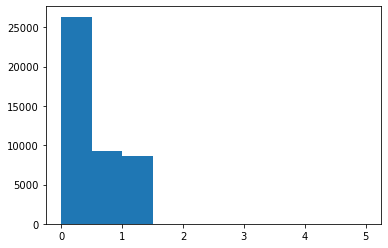

In [69]:
plt.hist(new_df['active_attentive_seconds_p'])
plt.show()

[0 2 3 4]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CatBoost model is fitted: True
CatBoost model parameters:
{'custom_metric': ['R2', 'NumErrors:greater_than=1', 'MAE', 'MAPE'], 'loss_function': 'RMSE', 'learning_rate': 0.2, 'iterations': 500}
Best Score:
{'learn': {'MAPE': 0.24834792670909123, 'MAE': 4.310227865260729, 'R2': 0.32821199380249877, 'RMSE': 10.042770148025815, 'NumErrors:greater_than=1': 0.5811235390222446}, 'validation': {'MAPE': 0.23077962235396446, 'MAE': 4.434682565877008, 'R2': 0.24762772472141248, 'RMSE': 12.590089942628044, 'NumErrors:greater_than=1': 0.5659353087536756}}
Best Iteration:
494


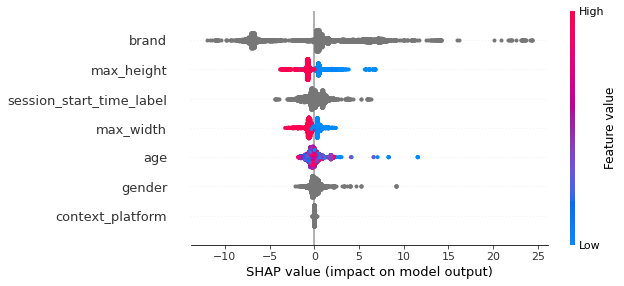

,Feature Id,Importances
0,brand,53.699662
1,max_height,12.472480
2,session_start_time_label,11.474545
3,age,11.257071
4,max_width,5.955913
5,gender,4.880428
6,context_platform,0.259901


In [36]:
#Catboost implementation Regression Method
# ad_time_playing seconds

import seaborn as sns
import shap
from catboost import CatBoostRegressor

categorical_features_indices = np.where(X_train.dtypes != np.float)[0]
print(categorical_features_indices)
model=CatBoostRegressor(iterations=500,
                        learning_rate=0.2,
                        custom_metric=['R2', 'NumErrors:greater_than=1', 'MAE', 'MAPE'],
                        #per_float_feature_quantization='3:border_count=1024',
                        loss_function='RMSE',)
model.fit(X_train, Y_train, cat_features=categorical_features_indices, eval_set=(X_val, Y_val), use_best_model = True,plot=True,verbose=False)
print('CatBoost model is fitted: ' + str(model.is_fitted()))
print('CatBoost model parameters:')
print(model.get_params())
print('Best Score:')
print(model.get_best_score())
print('Best Iteration:')
print(model.get_best_iteration())
#Analysis of shap features
import shap
shap_values = model.get_feature_importance(Pool(X_val, label=Y_val,cat_features=categorical_features_indices),
                                                                     type="ShapValues")
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]
shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], X_val.iloc[3,:])
shap.summary_plot(shap_values, X_val)
##Feature importance
model.get_feature_importance(prettified=True)

In [70]:
import random

random.seed(15)
#clicks_df = df[df['CONVERTED'] == 1]
#new_df = df[df['CONVERTED'] == 0].sample(1000000)
#combined_df = pd.concat([clicks_df, new_df], axis = 0)
X = new_df.drop(['attentive_seconds', 'active_attentive_seconds', 'passive_attentive_seconds', \
        'inactive_attentive_seconds', 'active_attentive_seconds_p', 'ad_length'], 1)
Y = new_df['active_attentive_seconds_p']
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size= .1, random_state=0)

[0 2 3 4]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CatBoost model is fitted: True
CatBoost model parameters:
{'custom_metric': ['R2', 'NumErrors:greater_than=1', 'MAE', 'MAPE'], 'loss_function': 'RMSE', 'learning_rate': 0.1, 'iterations': 500}
Best Score:
{'learn': {'MAPE': 0.2826590187640213, 'MAE': 0.28357984752937987, 'R2': 0.3634620028219665, 'RMSE': 0.3388014426566611, 'NumErrors:greater_than=1': 0.0}, 'validation': {'MAPE': 0.2872752907559028, 'MAE': 0.28825647753895434, 'R2': 0.34192345252555456, 'RMSE': 0.3424630470535218, 'NumErrors:greater_than=1': 0.00022619316896629722}}
Best Iteration:
499


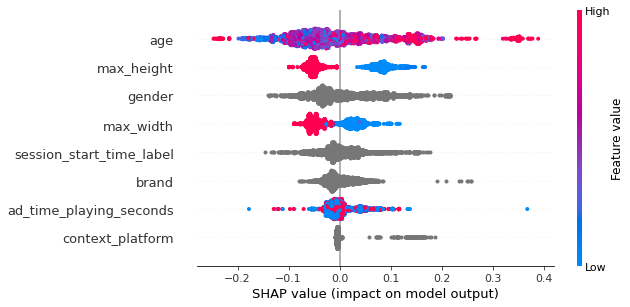

,Feature Id,Importances
0,age,41.959212
1,gender,12.140708
2,max_height,11.968873
3,session_start_time_label,10.949737
4,max_width,10.390230
5,ad_time_playing_seconds,5.921206
6,brand,5.448260
7,context_platform,1.221775


In [71]:
#Catboost implementation Regression Method
# attentive seconds

import seaborn as sns
import shap
from catboost import CatBoostRegressor

categorical_features_indices = np.where(X_train.dtypes != np.float)[0]
print(categorical_features_indices)
model=CatBoostRegressor(iterations=500,
                        learning_rate=0.1,
                        custom_metric=['R2', 'NumErrors:greater_than=1', 'MAE', 'MAPE'],
                        #per_float_feature_quantization='3:border_count=1024',
                        loss_function='RMSE',)
model.fit(X_train, Y_train, cat_features=categorical_features_indices, eval_set=(X_val, Y_val), use_best_model = True,plot=True,verbose=False)
print('CatBoost model is fitted: ' + str(model.is_fitted()))
print('CatBoost model parameters:')
print(model.get_params())
print('Best Score:')
print(model.get_best_score())
print('Best Iteration:')
print(model.get_best_iteration())
#Analysis of shap features
import shap
shap_values = model.get_feature_importance(Pool(X_val, label=Y_val,cat_features=categorical_features_indices),
                                                                     type="ShapValues")
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]
shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], X_val.iloc[3,:])
shap.summary_plot(shap_values, X_val)
##Feature importance
model.get_feature_importance(prettified=True)